In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import numpy as np
from scipy.io import loadmat, savemat
import sys
import src.config as cfg
import src.fitting as fit
import src.recon as recon
import visionloader as vl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from scipy import stats
import cv2
import jax
import jax.numpy as jnp
from stim_algos import GTDExperiment, DictionaryEntry
import estim_utils.triplet as triplet

%load_ext autoreload
%autoreload 2

In [2]:
FRAME_TIME = 1.5
STIM_TIME = 5e-5
REFRACTORY_DELAY = 200
GUARD_TIME = 0

In [3]:
def calculate_sig_stixels(sta, num_frames=9, alpha=1/10000, color_channels=None):
    """
    Sam Cooler sig stix implementation.

    Parameters:
        sta: STA of size t,y,x,c, with zero mean!
        num_frames: frames to use in noise calculation
        alpha: significance level
        color_channels: color channels to use
    Returns: tuple of booleans denoting the sig stix and the p values.
    
    Flips the STA and re-orders dims, but changes it back (doesn't mutate).

    """
    # Rearrange the dims and flip.
    sta = np.flip(np.moveaxis(sta,0,-2),axis=-2)

    if color_channels is None:
        color_channels = (0,1,2)

    early_frames = np.mean(sta[...,0:num_frames,color_channels], 3) 
    #std_this_cell = stats.median_absolute_deviation(early_frames.flatten())
    std_this_cell = stats.median_abs_deviation(early_frames.flatten())

    # Mean over color, square, sum over time
    input_frame = np.sum(np.power(np.mean(sta[...,-(num_frames+1):-1,
                               color_channels],3) / std_this_cell, 2), 2)

    # Chi squares survival = 1 - CDF
    pvalues = stats.chi2(df=num_frames).sf(input_frame) + np.finfo(float).eps 
    pvalues *= (sta.shape[0] * sta.shape[1]) # bonferroni correction

    # Put it back in order.
    sta = np.flip(np.moveaxis(sta,-2,0),axis=0)

    return pvalues < alpha, pvalues

## Get the gsorted cells

In [4]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
WNOISE_ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2023-09-19-0"
wnoise = "kilosort_data000/data000"
estim_neg = "data001"
outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)

vcd = vl.load_vision_data(os.path.join(WNOISE_ANALYSIS_BASE, dataset, wnoise),
                          os.path.basename(wnoise),
                          include_ei=True,
                          include_neurons=True,
                          include_params=True,
                          include_sta=True,
                          include_noise=True)
vcd.update_cell_type_classifications_from_text_file(os.path.join(WNOISE_ANALYSIS_BASE, dataset, wnoise, 
                                                                 f'{os.path.basename(wnoise)}.classification_deduped.txt'))

parameters = loadmat(os.path.join(outpath, 'parameters.mat'))
cells = parameters['cells'].flatten()
gsorted_cells = parameters['gsorted_cells'].flatten()

gsorted_cells_new = []
for i in range(len(gsorted_cells)):
    if 'on' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
        gsorted_cells_new.append(gsorted_cells[i])
    if 'off' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
        gsorted_cells_new.append(gsorted_cells[i])

gsorted_cells = np.array(gsorted_cells_new)
cells_to_use = cells[gsorted_cells]

## Constants

In [5]:
RESAMPLE_X = 320 # 80
RESAMPLE_Y = 160 # 40
ALPHA = 1e-10

In [6]:
N_SIGMAS_MASK = 2

In [7]:
stas = []
stas_fit = []
remove_cells = []

for cell in cells_to_use:
    sta = vcd.get_sta_for_cell(cell) 
    sta = np.stack([sta.red,sta.green,sta.blue])
    sta = np.swapaxes(sta,0,-1)
    
    # Resample the STA
    sta = np.asarray([cv2.resize(sta[i,...],(RESAMPLE_X,RESAMPLE_Y),interpolation=cv2.INTER_CUBIC)
           for i in range(sta.shape[0])
          ])
    sig_stix = calculate_sig_stixels(np.flip(sta,axis=0) - np.mean(sta),alpha=ALPHA)
    sta -= np.mean(sta)
    mask = sig_stix[0].astype(int)
    tc = np.sum(sta * mask[None,...,None],axis=(-1,-2,-3))
    sta = np.mean(sta[np.argmax(np.abs(tc)),...],axis=-1)
    
    # Fit 2d Gaussian.
    popt, pcov = fit.fit_gaussian2d(sta[...,None],np.argwhere(sig_stix[0]))
    
    if np.inf in np.absolute(pcov).flatten():
        remove_cells.append(cell)
        continue
        
    orig_n_pixels_x = sta.shape[1]
    orig_n_pixels_y = sta.shape[0]
    x = np.linspace(0,orig_n_pixels_x-1,RESAMPLE_X)
    y = np.linspace(0,orig_n_pixels_y-1,RESAMPLE_Y)
    xx,yy = np.meshgrid(x,y)
    out = fit.gaussian2d((xx,yy),*popt)
    out = recon.mask_gaussian_filter(out,popt,xx,yy,N_SIGMAS_MASK)
    stas_fit.append(out)
    stas.append(sta)
    
stas = np.asarray(stas)
stas_fit = np.asarray(stas_fit)

In [8]:
remove_cell_inds = np.searchsorted(cells_to_use, np.array(remove_cells))
gsorted_cells = np.setdiff1d(gsorted_cells, gsorted_cells[remove_cell_inds])
cells_to_use = np.setdiff1d(cells_to_use, np.array(remove_cells))

## Scale the STAs

In [9]:
FIRING_RATE = 2

In [10]:
try:
    encoding_filters = np.load(f'encoding_filters_{dataset}-onoff-{ALPHA}.npy')
except:
    encoding_filters = recon.get_encoding_filters_pooled(stas_fit,
                                                inds=[np.arange(0,stas.shape[0])],
                                                firing_rates=[FIRING_RATE],
                                                stixels=cfg.STIXEL_SIZES)
    np.save(f'encoding_filters_{dataset}-onoff-{ALPHA}.npy', encoding_filters)

## Compute reconstruction filters

In [ ]:
# Learn reconstruction filters together

try:
    decoding_filters = np.load(f'decoding_filters_{dataset}-onoff-{ALPHA}.npy')
except:
    decoding_filters = recon.learn_recon_filters_pooled(encoding_filters.reshape(-1,RESAMPLE_Y,RESAMPLE_X))
    np.save(f'decoding_filters_{dataset}-onoff-{ALPHA}.npy', decoding_filters)

In [11]:
# Learn reconstruction filters one cell at a time

try:
    decoding_filters = np.load(f'decoding_filters_{dataset}-onoff-{ALPHA}-individual.npy')
except:
    decoding_filters = recon.learn_recon_filters_pooled_individual(encoding_filters.reshape(-1,RESAMPLE_Y,RESAMPLE_X))
    np.save(f'decoding_filters_{dataset}-onoff-{ALPHA}-individual.npy', decoding_filters)

In [12]:
encoding_filters.shape, decoding_filters.shape

((255, 51200), (255, 51200))

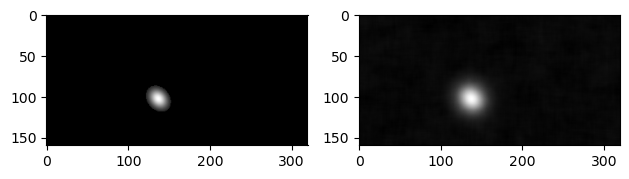

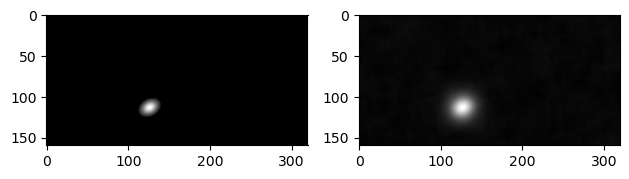

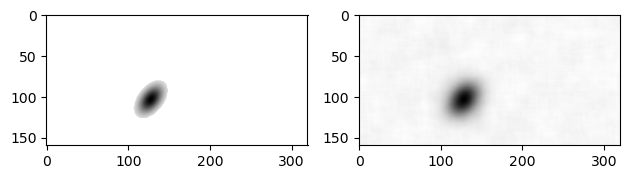

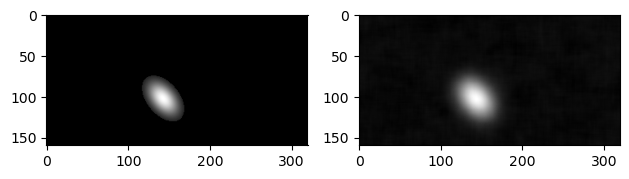

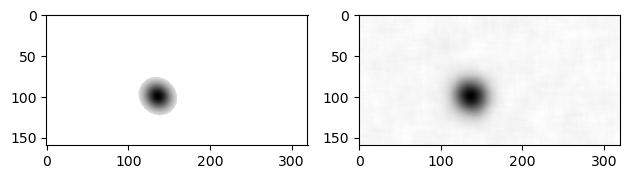

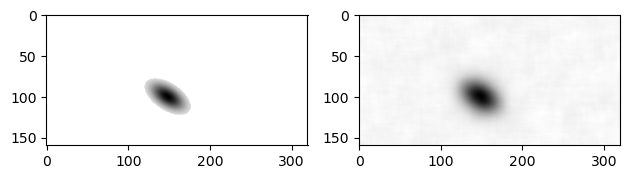

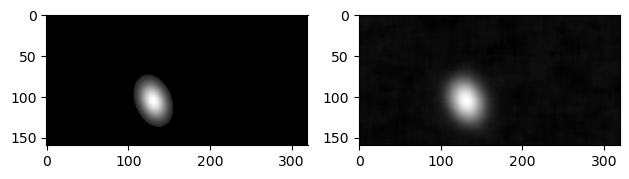

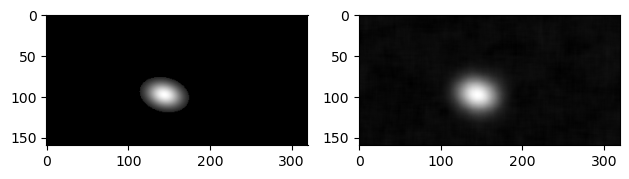

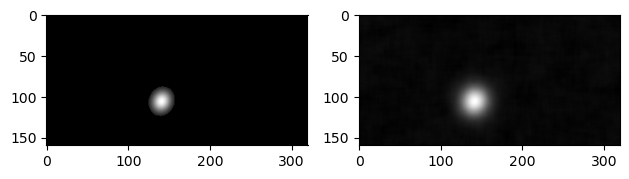

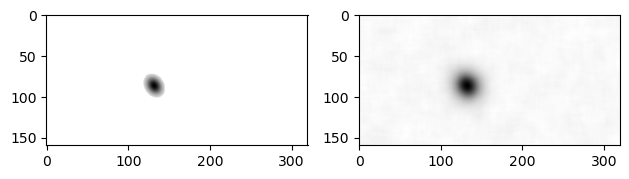

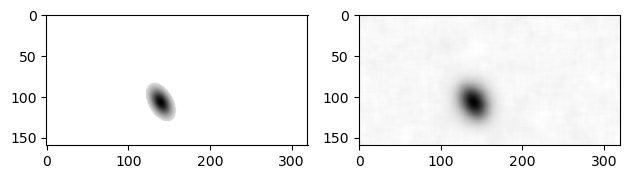

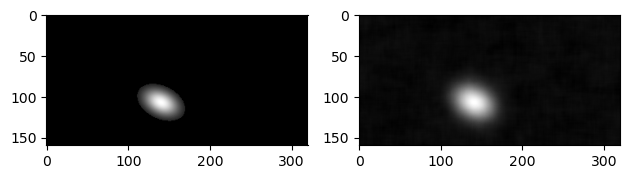

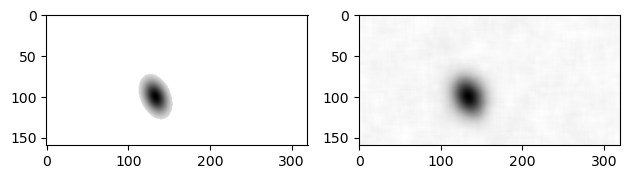

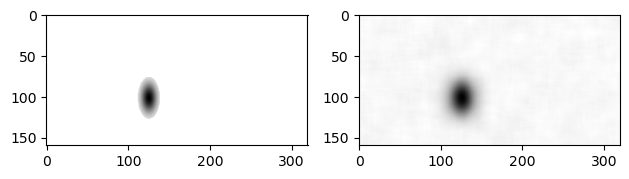

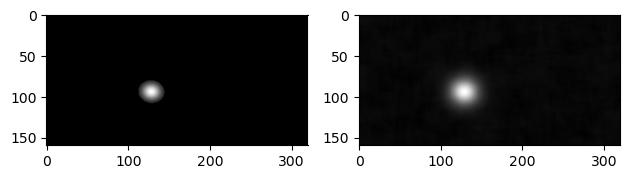

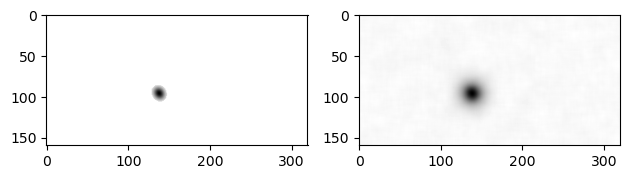

KeyboardInterrupt: Interrupted by user

In [13]:
for i in range(encoding_filters.shape[0]):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(encoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')

    plt.tight_layout()
    plt.show()
    input()

## we do greedy ..

In [14]:
mask = (np.sum(np.abs(encoding_filters),axis=0)!=0).astype(int)
sig_stix = np.argwhere(mask).flatten()

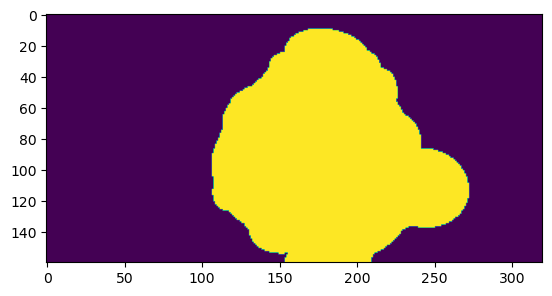

In [15]:
plt.imshow(mask.reshape(160,320))

In [16]:
xlim = [40, 310]

In [17]:
dict_data_1elec = loadmat(f'estim_dictionary_1elec_{dataset}-onoff.mat', squeeze_me=True, 
                          struct_as_record=False)
dictionary_matrix = dict_data_1elec['dictionary_matrix']
dictionary_matrix = dictionary_matrix[:, np.setdiff1d(np.arange(dictionary_matrix.shape[1], dtype=int),
                                                      np.array(remove_cell_inds))]
electrodes_amplitudes = dict_data_1elec['EA']

In [18]:
dictionary_matrix.shape, decoding_filters.shape

((6443, 255), (255, 51200))

In [19]:
decoder = decoding_filters.reshape(decoding_filters.shape[0], 1, 160, 320)

dictionary_info = []
for entry in range(dictionary_matrix.shape[0]):
    dictionary_info.append(
        DictionaryEntry(
           electrodes= [electrodes_amplitudes[entry, 0]],
           pulses_indices=[electrodes_amplitudes[entry, 1]],
           num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
           )
        )

In [20]:
STIXEL_SIZE = 64

In [ ]:
NUM_REPEATS = 100     # TODO: set this
error_map_avg = np.zeros(decoding_filters.shape[1])
signed_error_map_avg = np.zeros(decoding_filters.shape[1])

for i in range(NUM_REPEATS):
    print(f'Repeat {i+1}')
    
    visual_stimulus = recon.get_random_stimuli_jitter(1, STIXEL_SIZE, RESAMPLE_X, RESAMPLE_Y)
    visual_stimulus = visual_stimulus.reshape(1, 160, 320)

    # plt.figure()
    # plt.imshow(visual_stimulus[0] * mask.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    experiment_without_sm = GTDExperiment(
        dictionary=dictionary_matrix, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm = experiment_without_sm.run()
    masked_expt = experiment_without_sm.reconstruction[0].flatten() * mask

    # plt.figure()
    # plt.imshow(masked_expt.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    masked_stimulus = jnp.array(visual_stimulus[0].reshape(160*320, 1).ravel() * mask)
    masked_decoder = jnp.array((decoding_filters.T * mask[:, None]))

    losses, x = recon.get_optimal_recon_jax(masked_decoder, masked_stimulus, 
                                            jnp.array(np.absolute(np.random.normal(size=decoding_filters.shape[0]))),
                                            step_size=2, n_steps=1000, verbose=True, obj_tol=1e-5)

    # plt.figure()
    # plt.plot(losses)
    # plt.show()

    masked_opt = (decoding_filters.T @ x) * mask
    # plt.figure()
    # plt.imshow(masked_opt.reshape(160,320),cmap='gray', vmin=-1, vmax=1)
    # plt.xlim([70,250])
    # plt.show()

    error_map = (masked_opt - masked_expt)**2 / np.linalg.norm(visual_stimulus[0].ravel() * mask)**2
    signed_error_map = masked_opt - masked_expt

    error_map_avg += error_map
    signed_error_map_avg += signed_error_map

    # input()

error_map_avg = error_map_avg / NUM_REPEATS
signed_error_map_avg = signed_error_map_avg / NUM_REPEATS

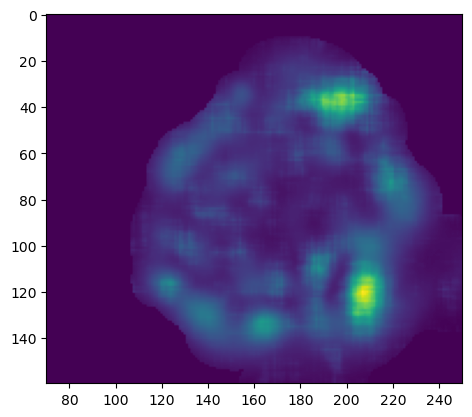

In [22]:
plt.figure()
plt.imshow(error_map_avg.reshape(160, 320))
plt.xlim([70,250])
plt.show()

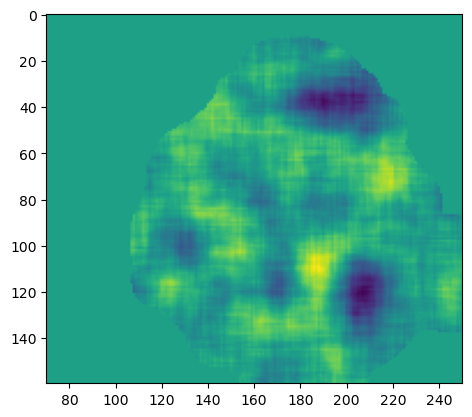

In [23]:
plt.figure()
plt.imshow(signed_error_map_avg.reshape(160, 320))
plt.xlim([70,250])
plt.show()

In [ ]:
np.save(f'error_map_avg_{dataset}.npy', error_map_avg)
np.save(f'signed_error_map_avg_{dataset}.npy', signed_error_map_avg)

In [21]:
error_map_avg = np.load(f'error_map_avg_{dataset}.npy')
signed_error_map_avg = np.load(f'signed_error_map_avg_{dataset}.npy')

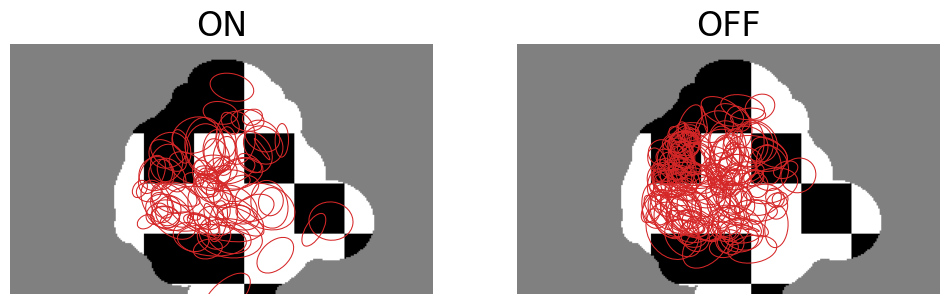

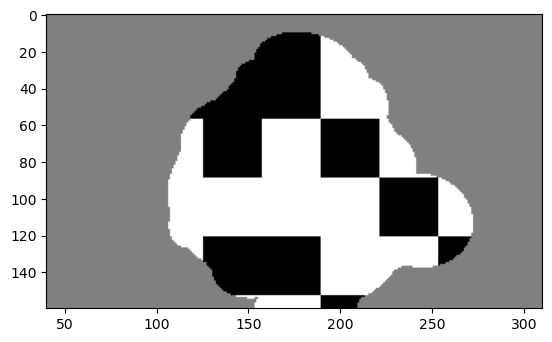

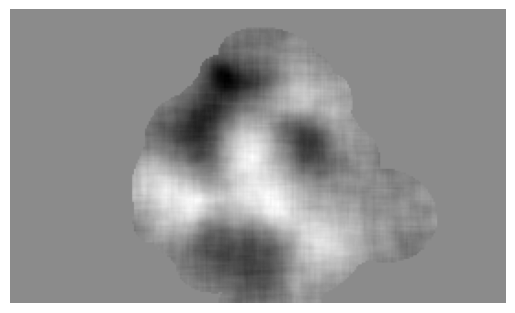

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

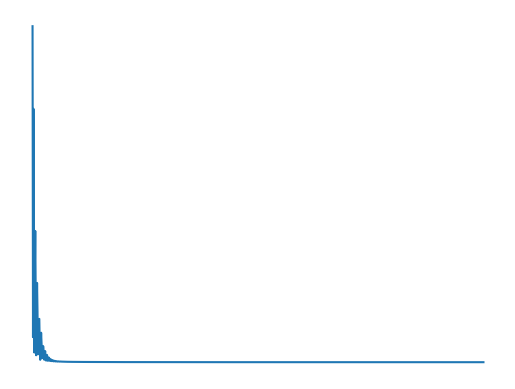

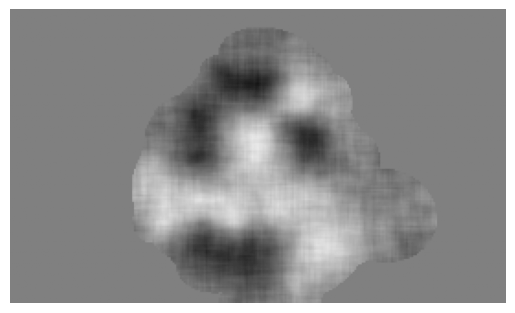

In [57]:
visual_stimulus = recon.get_random_stimuli_jitter(1, STIXEL_SIZE, RESAMPLE_X, RESAMPLE_Y)
visual_stimulus = visual_stimulus.reshape(1, 160, 320)

NUM_SIGMAS_RF_FIT = 2
CONVERSION_FACTOR = 8
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for cell in cells_to_use:
    # Get the STA fits. 
    sta_fit = vcd.get_stafit_for_cell(cell)
    mu_x = sta_fit.center_x * CONVERSION_FACTOR
    mu_y = sta_fit.center_y * CONVERSION_FACTOR
    sigma_y = sta_fit.std_x * CONVERSION_FACTOR
    sigma_x = sta_fit.std_y * CONVERSION_FACTOR
    degrees = sta_fit.rot * (180 / np.pi) * -1
    fit = Ellipse(xy = (mu_x,mu_y), width = NUM_SIGMAS_RF_FIT * sigma_y,
            height = NUM_SIGMAS_RF_FIT * sigma_x,
            angle = degrees,
            edgecolor='tab:red', facecolor='none', linewidth=0.75)

    if 'on' in vcd.get_cell_type_for_cell(cell).lower():
        # ax[ind+1].set(xlim=[0,(width-1)],ylim=[0,(height-1)],aspect=1)
        # ax[ind].set(xlim=[0,(width-1)],ylim=[(height-1),0],aspect=1)\
        ax[0].add_patch(fit)
        ax[0].set_xlim([40, 310])
        # ax[0].set_ylim([0, 160])

    elif 'off' in vcd.get_cell_type_for_cell(cell).lower():
        # ax[ind+1].set(xlim=[0,(width-1)],ylim=[0,(height-1)],aspect=1)
        # ax[ind].set(xlim=[0,(width-1)],ylim=[(height-1),0],aspect=1)\
        ax[1].add_patch(fit)
        ax[1].set_xlim([40, 310])
        # ax[1].set_ylim([0, 160])
ax[0].imshow(np.flip(visual_stimulus[0] * mask.reshape(160,320), axis=0),cmap='gray')
ax[1].imshow(np.flip(visual_stimulus[0] * mask.reshape(160,320), axis=0),cmap='gray')
ax[0].set_xlim(xlim)
ax[0].set_ylim([0, 160])
ax[1].set_xlim(xlim)
ax[1].set_ylim([0, 160])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('ON', fontsize=24)
ax[1].set_title('OFF', fontsize=24)
plt.savefig(f'mosaics_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

plt.figure()
plt.imshow(visual_stimulus[0] * mask.reshape(160,320),cmap='gray')
plt.xlim(xlim)
# plt.axis('off')
plt.savefig(f'visual_stimulus_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

experiment_without_sm = GTDExperiment(
    dictionary=dictionary_matrix, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
    dictionary_info=dictionary_info, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
    visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
    visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
    frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
    stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
    refractory_delay = REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
    guard_time = GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
    )

print(flush=True)
#returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
sef_array_no_sm = experiment_without_sm.run()
masked_expt = experiment_without_sm.reconstruction[0].flatten() * mask

plt.figure()
plt.imshow(masked_expt.reshape(160,320),cmap='gray')
plt.xlim(xlim)
plt.axis('off')
plt.savefig(f'recon_1elec_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

masked_stimulus = jnp.array(visual_stimulus[0].reshape(160*320, 1).ravel() * mask)
masked_decoder = jnp.array((decoding_filters.T * mask[:, None]))

losses, x = recon.get_optimal_recon_jax(masked_decoder, masked_stimulus, 
                                        jnp.array(np.absolute(np.random.normal(size=decoding_filters.shape[0]))),
                                        step_size=2, n_steps=1000, verbose=True, obj_tol=1e-5)

plt.figure()
plt.plot(losses)
plt.axis('off')
plt.show()

masked_opt = (decoding_filters.T @ x) * mask
plt.figure()
plt.imshow(masked_opt.reshape(160,320),cmap='gray', vmin=-1, vmax=1)
plt.xlim(xlim)
plt.axis('off')
plt.savefig(f'recon_optimal_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [58]:
cell_products = np.zeros(decoding_filters.shape[0])
for i in range(decoding_filters.shape[0]):
    # plt.figure()
    # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
    # plt.show()

    pixel_mask = (encoding_filters[i, :] != 0).astype(int)

    # plt.figure()
    # plt.imshow((decoding_filters[i, :] * pixel_mask).reshape(160, 320), cmap='gray')
    # plt.show()

    cell_products[i] = ((decoding_filters[i, :] * pixel_mask)**2 @ error_map_avg / 
                         (np.linalg.norm(error_map_avg) * np.linalg.norm((decoding_filters[i, :] * pixel_mask)**2)))

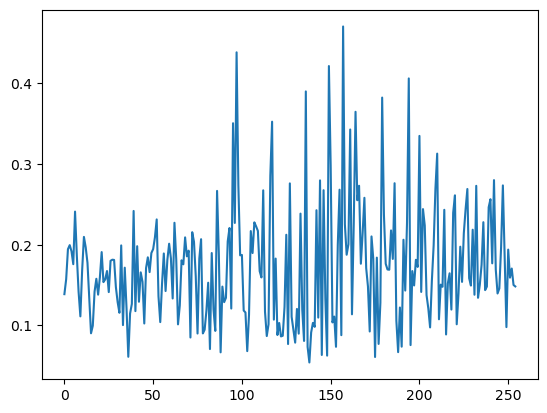

In [59]:
plt.figure()
plt.plot(cell_products)

In [60]:
def get_selectivity(dictionary):
    selectivities = np.zeros(len(dictionary))
    for i in range(len(dictionary)):
        selectivity_elements = dictionary[i, :] * np.multiply.reduce(
            (1 - dictionary[np.setdiff1d(np.arange(len(dictionary), dtype=int), i), :]),
            axis=0)

        selectivities[i] = np.amax(selectivity_elements)

    return selectivities

[157  97 149 194 136 179 164 117  95 161]


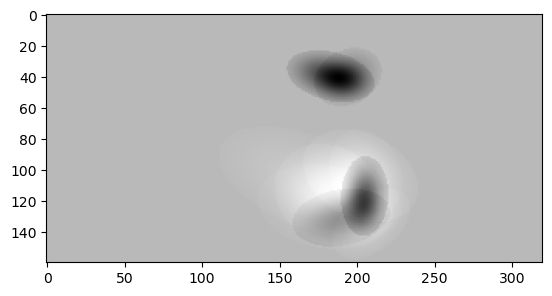

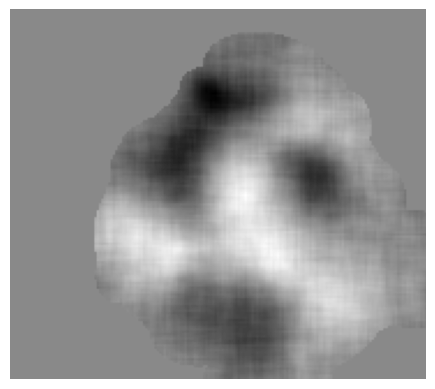

[157  97 149 194 136 179 164 117  95 161 200 210 150 116 242 144 186 127
 247  98 166 232 227 209 155 146 112  86 220 169]


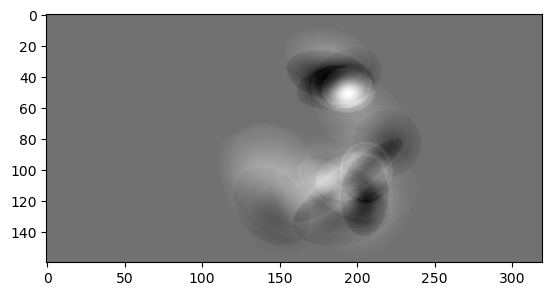

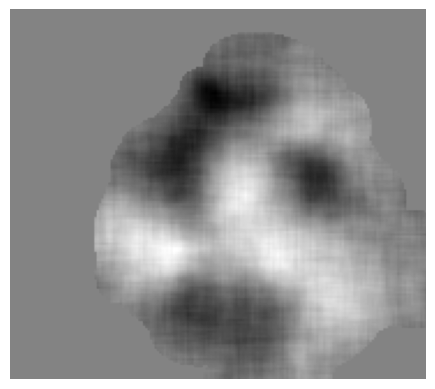

[157  97 149 194 136 179 164 117  95 161 200 210 150 116 242 144 186 127
 247  98 166 232 227 209 155 146 112  86 220 169 240 165 239 202 226 214
 142  39   6 219 133 180  52 236 107  62 193  96 163 158]


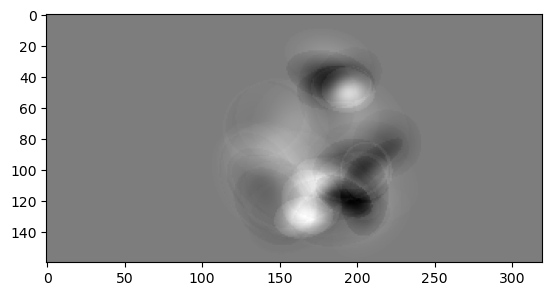

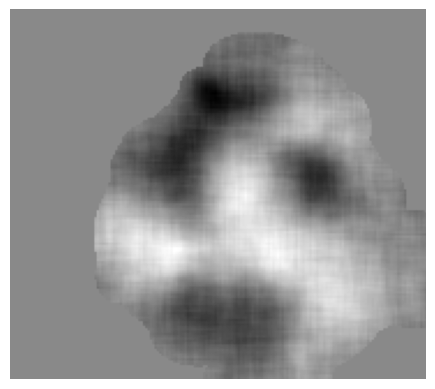

[157  97 149 194 136 179 164 117  95 161 200 210 150 116 242 144 186 127
 247  98 166 232 227 209 155 146 112  86 220 169 240 165 239 202 226 214
 142  39   6 219 133 180  52 236 107  62 193  96 163 158 203 108  93 230
 184 109 105  72 168 225 125 173  11  51  68  77 191  92  73  59]


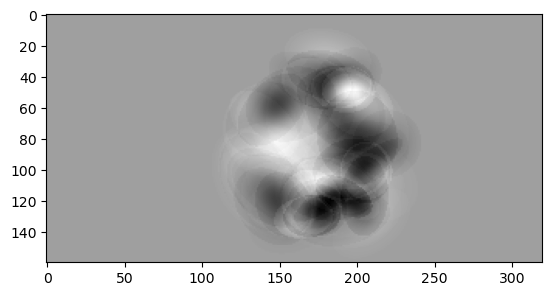

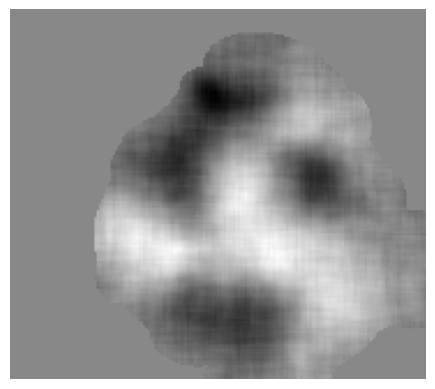

[157  97 149 194 136 179 164 117  95 161 200 210 150 116 242 144 186 127
 247  98 166 232 227 209 155 146 112  86 220 169 240 165 239 202 226 214
 142  39   6 219 133 180  52 236 107  62 193  96 163 158 203 108  93 230
 184 109 105  72 168 225 125 173  11  51  68  77 191  92  73  59 160 154
   3  32 208  41 223 246  12  50   2 250  70   4  21  49  83 106  56  87]


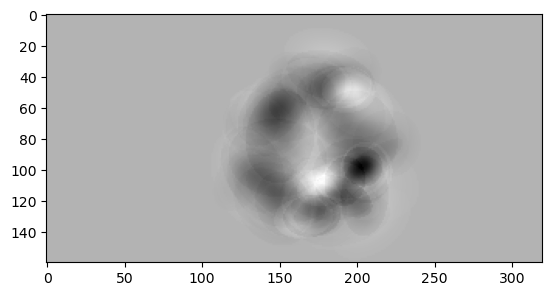

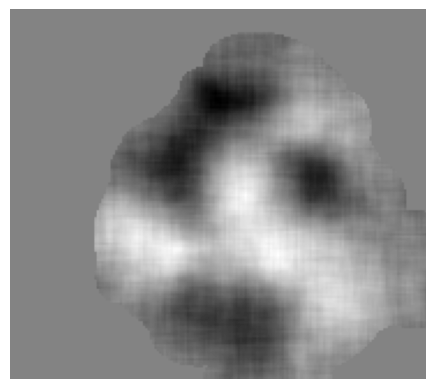

[157  97 149 194 136 179 164 117  95 161 200 210 150 116 242 144 186 127
 247  98 166 232 227 209 155 146 112  86 220 169 240 165 239 202 226 214
 142  39   6 219 133 180  52 236 107  62 193  96 163 158 203 108  93 230
 184 109 105  72 168 225 125 173  11  51  68  77 191  92  73  59 160 154
   3  32 208  41 223 246  12  50   2 250  70   4  21  49  83 106  56  87
 159 100  99   7  69  47 176  60 248  76 119 174 185  63  27 198  58  28
  66  26]


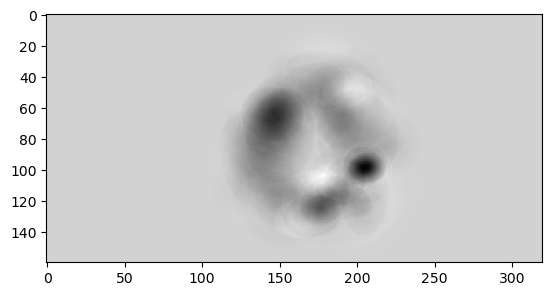

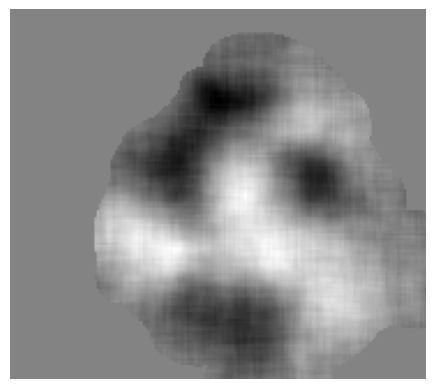

[157  97 149 194 136 179 164 117  95 161 200 210 150 116 242 144 186 127
 247  98 166 232 227 209 155 146 112  86 220 169 240 165 239 202 226 214
 142  39   6 219 133 180  52 236 107  62 193  96 163 158 203 108  93 230
 184 109 105  72 168 225 125 173  11  51  68  77 191  92  73  59 160 154
   3  32 208  41 223 246  12  50   2 250  70   4  21  49  83 106  56  87
 159 100  99   7  69  47 176  60 248  76 119 174 185  63  27 198  58  28
  66  26  13 241 167 181   5  67 235 199  34 170  46 252 182 243 183  10
  24 196 110  48]


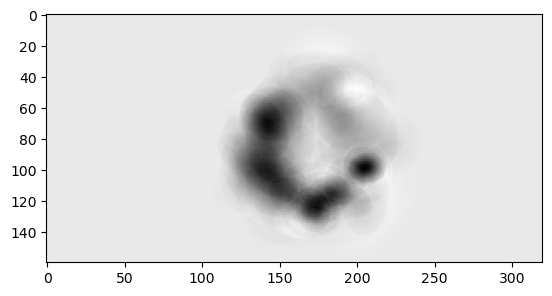

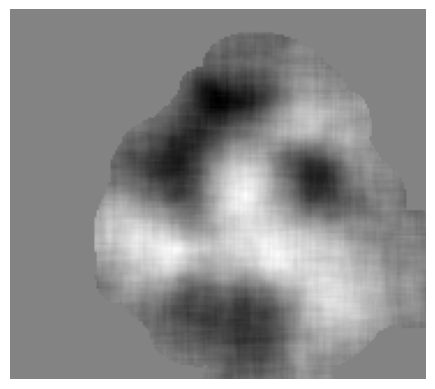

[157  97 149 194 136 179 164 117  95 161 200 210 150 116 242 144 186 127
 247  98 166 232 227 209 155 146 112  86 220 169 240 165 239 202 226 214
 142  39   6 219 133 180  52 236 107  62 193  96 163 158 203 108  93 230
 184 109 105  72 168 225 125 173  11  51  68  77 191  92  73  59 160 154
   3  32 208  41 223 246  12  50   2 250  70   4  21  49  83 106  56  87
 159 100  99   7  69  47 176  60 248  76 119 174 185  63  27 198  58  28
  66  26  13 241 167 181   5  67 235 199  34 170  46 252 182 243 183  10
  24 196 110  48  43 217  74  20 111 251 228  18   1  23 207  44 224  22
  81 216  55 212 234 253]


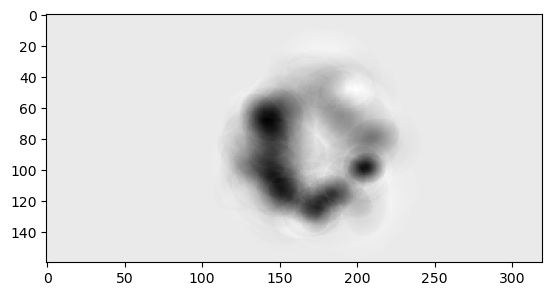

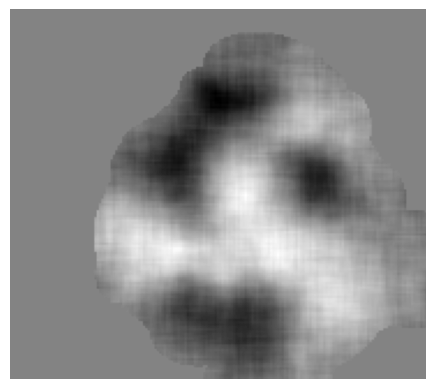

In [61]:
error_list = []
num_cells_list = [10, 30, 50, 70, 90, 110, 130, 150]
num_cells_with_high_sel = []
sel_thresh = 0.95
num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix.T) > sel_thresh))

for j in range(len(num_cells_list)):
    num_cells = num_cells_list[j]
    bad_cell_inds = np.flip(np.argsort(cell_products))[:num_cells]
    print(bad_cell_inds)

    bad_superimposed = np.zeros(encoding_filters.shape[1])
    for i in bad_cell_inds:
        bad_superimposed += encoding_filters[i, :]

    plt.figure()
    plt.imshow(bad_superimposed.reshape(160, 320), cmap='gray')
    plt.show()

    augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[1]))
    augmented_EA = np.zeros((len(bad_cell_inds), 2))
    for i in range(len(bad_cell_inds)):
        augmented_entries[i, bad_cell_inds[i]] = 1
        augmented_EA[i, 0] = 519 + i
        augmented_EA[i, 1] = 30

    dictionary_matrix_aug = np.vstack((dictionary_matrix, augmented_entries))
    electrodes_amplitudes_aug = np.vstack((electrodes_amplitudes, augmented_EA))

    num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix_aug.T) > sel_thresh))

    dictionary_info_aug = []
    for entry in range(dictionary_matrix_aug.shape[0]):
        dictionary_info_aug.append(
            DictionaryEntry(
            electrodes= [electrodes_amplitudes_aug[entry, 0]],
            pulses_indices=[electrodes_amplitudes_aug[entry, 1]],
            num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
            )
            )
        
    experiment_without_sm_aug = GTDExperiment(
        dictionary=dictionary_matrix_aug, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info_aug, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm_aug = experiment_without_sm_aug.run()
    masked_aug = experiment_without_sm_aug.reconstruction[0].flatten() * mask

    plt.figure()
    plt.imshow(masked_aug.reshape(160,320),cmap='gray')
    plt.xlim([70,250])
    plt.axis('off')
    plt.savefig(f'recon_augmented{num_cells}_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    
    error_list.append(experiment_without_sm_aug.compute_reconstruction_mse())

In [62]:
num_cells_with_high_sel, num_cells_list

([76, 82, 99, 110, 119, 133, 146, 160, 172],
 [10, 30, 50, 70, 90, 110, 130, 150])

In [63]:
cell_products_signed = np.zeros(decoding_filters.shape[0])
for i in range(decoding_filters.shape[0]):
    # plt.figure()
    # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
    # plt.show()

    pixel_mask = (encoding_filters[i, :] != 0).astype(int)

    # plt.figure()
    # plt.imshow((decoding_filters[i, :] * pixel_mask).reshape(160, 320), cmap='gray')
    # plt.show()

    cell_products_signed[i] = (decoding_filters[i, :] * pixel_mask) @ signed_error_map_avg 

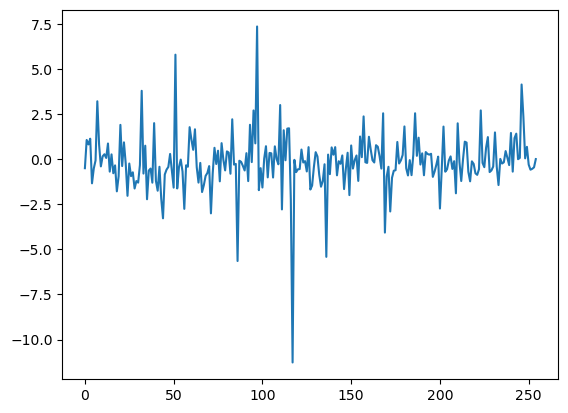

In [64]:
plt.figure()
plt.plot(cell_products_signed)

[ 97  51 246  32   7 110 223  95 186 168]


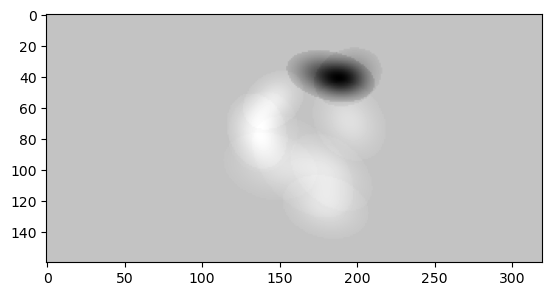

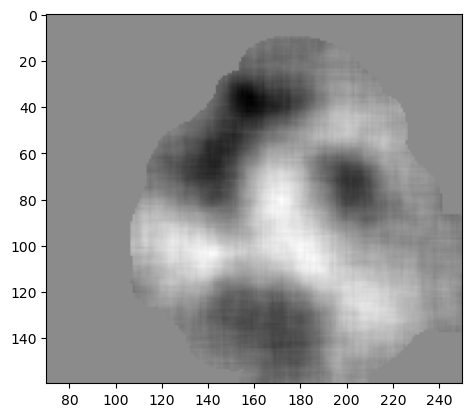

[ 97  51 246  32   7 110 223  95 186 168 157 247  83  39 210  93  20 180
 202  59 115 114  62 112 231 240 243 155 160 227]


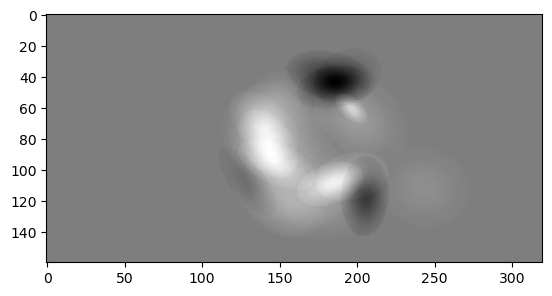

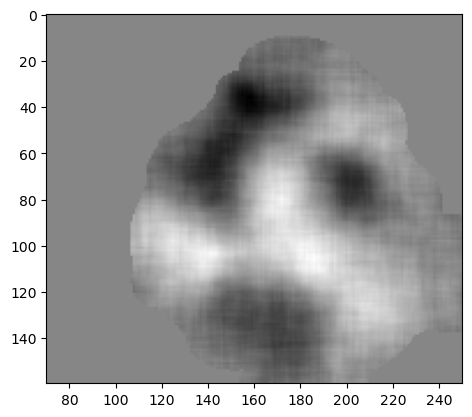

[ 97  51 246  32   7 110 223  95 186 168 157 247  83  39 210  93  20 180
 202  59 115 114  62 112 231 240 243 155 160 227 188 242   3  60   1 214
 176  22 215  77  96  13   2   8 164 150  34 102 107 165]


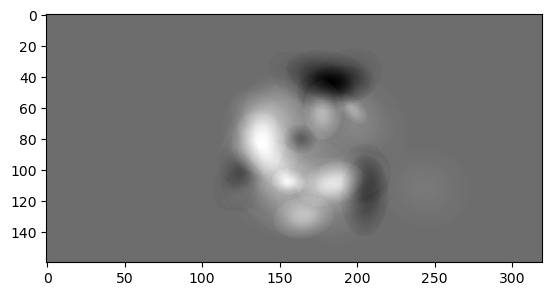

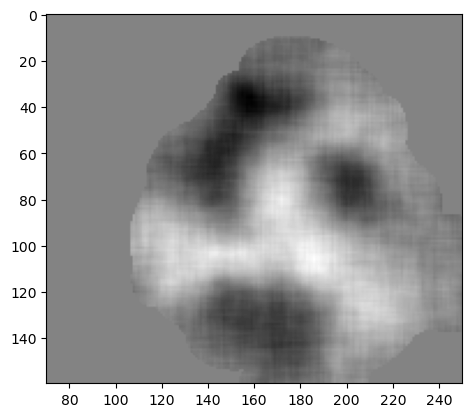

[ 97  51 246  32   7 110 223  95 186 168 157 247  83  39 210  93  20 180
 202  59 115 114  62 112 231 240 243 155 160 227 188 242   3  60   1 214
 176  22 215  77  96  13   2   8 164 150  34 102 107 165 249 141 126 139
 226  73 161 122  61  75 237  80 192 130  81 148 104  91 105 190]


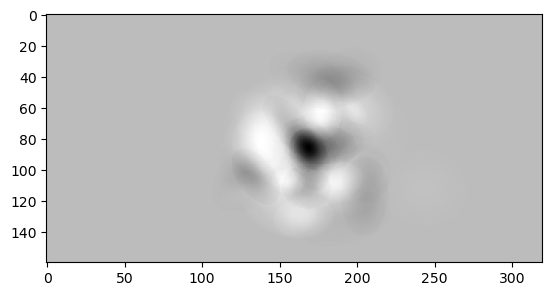

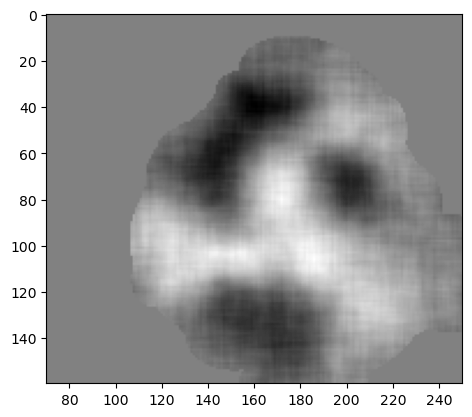

[ 97  51 246  32   7 110 223  95 186 168 157 247  83  39 210  93  20 180
 202  59 115 114  62 112 231 240 243 155 160 227 188 242   3  60   1 214
 176  22 215  77  96  13   2   8 164 150  34 102 107 165 249 141 126 139
 226  73 161 122  61  75 237  80 192 130  81 148 104  91 105 190 195 193
  48  11  15 137 185 194 140 179 145 153 187 166  10 206 131 199 156 238]


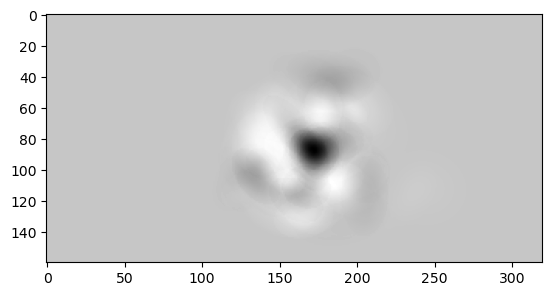

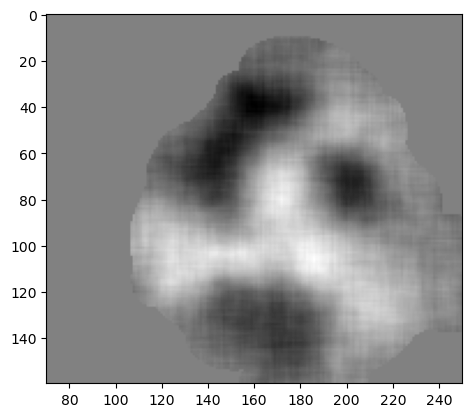

[ 97  51 246  32   7 110 223  95 186 168 157 247  83  39 210  93  20 180
 202  59 115 114  62 112 231 240 243 155 160 227 188 242   3  60   1 214
 176  22 215  77  96  13   2   8 164 150  34 102 107 165 249 141 126 139
 226  73 161 122  61  75 237  80 192 130  81 148 104  91 105 190 195 193
  48  11  15 137 185 194 140 179 145 153 187 166  10 206 131 199 156 238
 245  12 248 101 234 108 254 244 213  54  78 118 152 183 162 113 178   6
 205  87]


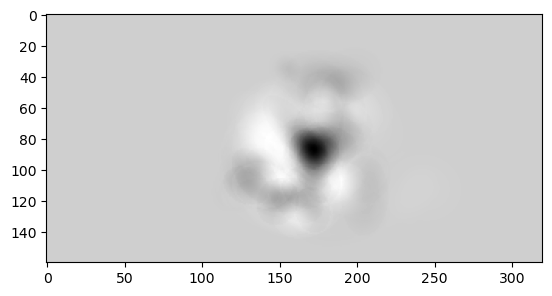

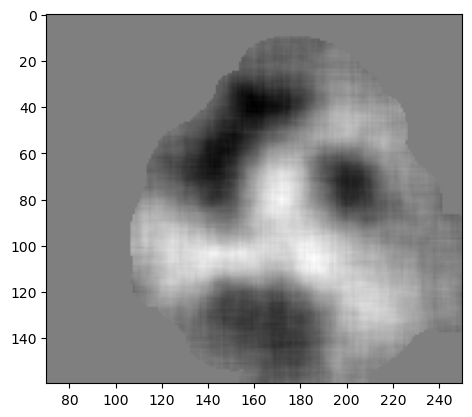

[ 97  51 246  32   7 110 223  95 186 168 157 247  83  39 210  93  20 180
 202  59 115 114  62 112 231 240 243 155 160 227 188 242   3  60   1 214
 176  22 215  77  96  13   2   8 164 150  34 102 107 165 249 141 126 139
 226  73 161 122  61  75 237  80 192 130  81 148 104  91 105 190 195 193
  48  11  15 137 185 194 140 179 145 153 187 166  10 206 131 199 156 238
 245  12 248 101 234 108 254 244 213  54  78 118 152 183 162 113 178   6
 205  87 124 208 143 218  88  94 211 158 236 123 163 224 159  65 177  25
 235  23 144  85]


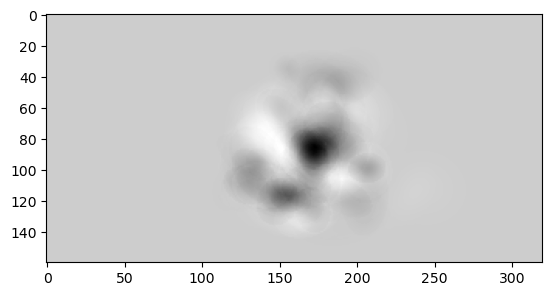

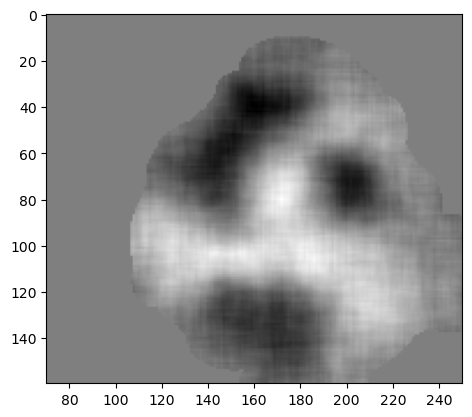

[ 97  51 246  32   7 110 223  95 186 168 157 247  83  39 210  93  20 180
 202  59 115 114  62 112 231 240 243 155 160 227 188 242   3  60   1 214
 176  22 215  77  96  13   2   8 164 150  34 102 107 165 249 141 126 139
 226  73 161 122  61  75 237  80 192 130  81 148 104  91 105 190 195 193
  48  11  15 137 185 194 140 179 145 153 187 166  10 206 131 199 156 238
 245  12 248 101 234 108 254 244 213  54  78 118 152 183 162 113 178   6
 205  87 124 208 143 218  88  94 211 158 236 123 163 224 159  65 177  25
 235  23 144  85 219  74 135 109 189 198  84 250  31 239  57  17  89  21
  70   9 230  58  42 171]


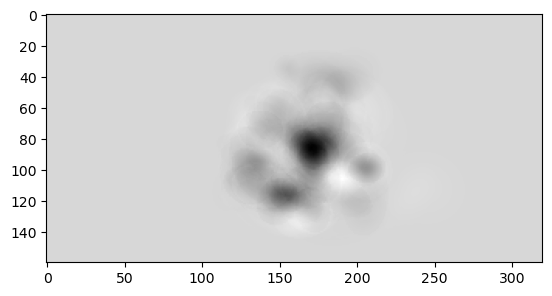

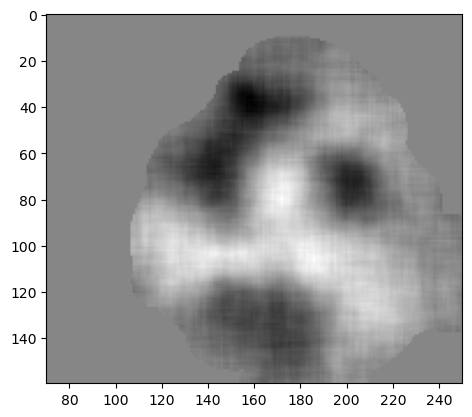

In [65]:
error_list_signed = []
# num_cells_with_high_sel = []
# sel_thresh = 0.95
# num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix.T) > sel_thresh))

for j in range(len(num_cells_list)):
    num_cells = num_cells_list[j]
    bad_cell_inds = np.flip(np.argsort(cell_products_signed))[:num_cells]
    print(bad_cell_inds)

    bad_superimposed = np.zeros(encoding_filters.shape[1])
    for i in bad_cell_inds:
        bad_superimposed += encoding_filters[i, :]

    plt.figure()
    plt.imshow(bad_superimposed.reshape(160, 320), cmap='gray')
    plt.show()

    augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[1]))
    augmented_EA = np.zeros((len(bad_cell_inds), 2))
    for i in range(len(bad_cell_inds)):
        augmented_entries[i, bad_cell_inds[i]] = 1
        augmented_EA[i, 0] = 519 + i
        augmented_EA[i, 1] = 30

    dictionary_matrix_aug = np.vstack((dictionary_matrix, augmented_entries))
    electrodes_amplitudes_aug = np.vstack((electrodes_amplitudes, augmented_EA))

    # num_cells_with_high_sel.append(np.count_nonzero(get_selectivity(dictionary_matrix_aug.T) > sel_thresh))

    dictionary_info_aug = []
    for entry in range(dictionary_matrix_aug.shape[0]):
        dictionary_info_aug.append(
            DictionaryEntry(
            electrodes= [electrodes_amplitudes_aug[entry, 0]],
            pulses_indices=[electrodes_amplitudes_aug[entry, 1]],
            num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
            )
            )
        
    experiment_without_sm_aug = GTDExperiment(
        dictionary=dictionary_matrix_aug, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
        dictionary_info=dictionary_info_aug, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
        visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
        visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
        frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
        stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
        refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
        guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
        )

    print(flush=True)
    #returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
    sef_array_no_sm_aug = experiment_without_sm_aug.run()
    masked_aug = experiment_without_sm_aug.reconstruction[0].flatten() * mask

    plt.figure()
    plt.imshow(masked_aug.reshape(160,320),cmap='gray')
    plt.xlim([70,250])
    plt.show()
    
    error_list_signed.append(experiment_without_sm_aug.compute_reconstruction_mse())

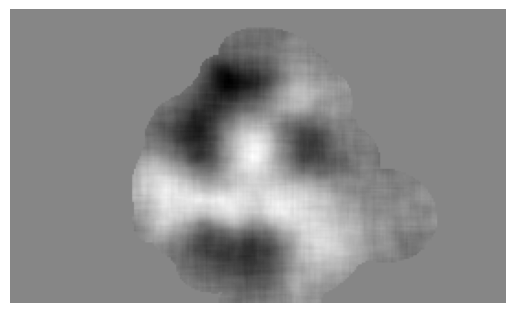

In [66]:
dictionary_matrix_sel = np.eye(len(gsorted_cells))

electrodes_amplitudes_sel = np.zeros((len(dictionary_matrix_sel), 2))
for i in range(len(dictionary_matrix_sel)):
    electrodes_amplitudes_sel[i, 0] = 519 + i
    electrodes_amplitudes_sel[i, 1] = 30

dictionary_info_sel = []
for entry in range(dictionary_matrix_sel.shape[0]):
    dictionary_info_sel.append(
        DictionaryEntry(
           electrodes= [electrodes_amplitudes_sel[entry, 0]],
           pulses_indices=[electrodes_amplitudes_sel[entry, 1]],
           num_stims_used_overall=3 #triphasic pulses, do the same thing for all dictionary entries for rat experiments in near term
           )
        )

experiment_without_sm_sel = GTDExperiment(
    dictionary=dictionary_matrix_sel, #2D np.ndarray (#entries, #cells), activation probabilities 0.0-1.0
    dictionary_info=dictionary_info_sel, #See above, Currently ONLY DO SINGLE ELECTRODE STIMULATION, ie one electrode in the list , one pulse index
    visual_stimulus=visual_stimulus * mask.reshape((1, 160, 320)), #3D np.ndarray (#frames, length, width), for our purposes #frames=1 
    visual_decoder=decoder * mask.reshape((1, 1, 160, 320)), #4D np.ndarray (#cells, #frames, length, width) , once again #frames=1 for our purposes
    frame_time = FRAME_TIME, #float, time in SECONDS you want experiment to run, 1 second means 20000 time units on litke system
    stim_time = STIM_TIME, #float, Time in SECONDS between samples on litke array, ie 20kHz
    refractory_delay=REFRACTORY_DELAY, #Time in INTEGER multiples of stim time to allow stimulated cells to recover, 5ms=5e-3s = 5e-5*100
    guard_time=GUARD_TIME #Time in INTEGER multiples of stim time to separate subsequent estims (so spike sorting is possible)
    )

print(flush=True)
#returns np.ndarray of dimension (#stims, 3) corresponding to the SEF!
sef_array_no_sm_sel = experiment_without_sm_sel.run()
masked_sel = experiment_without_sm_sel.reconstruction[0].flatten() * mask

plt.figure()
plt.imshow(masked_sel.reshape(160,320),cmap='gray')
plt.xlim(xlim)
plt.axis('off')
plt.savefig(f'recon_selective_{dataset}.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [67]:
base_err = experiment_without_sm.compute_reconstruction_mse()
opt_err = recon.n_mse(visual_stimulus.flatten()[..., None], 
                      masked_opt[..., None], sig_stix)
sel_err = experiment_without_sm_sel.compute_reconstruction_mse()

In [68]:
base_err, opt_err, sel_err

(0.5245174753077803, array([0.45108374]), 0.48979081804638586)

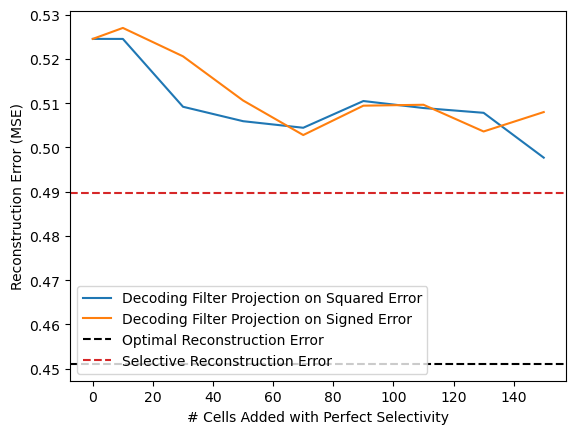

In [69]:
plt.figure()
plt.plot([0] + num_cells_list, [base_err] + error_list,
         label='Decoding Filter Projection on Squared Error')
plt.plot([0] + num_cells_list, [base_err] + error_list_signed,
         label='Decoding Filter Projection on Signed Error')
plt.axhline(opt_err, linestyle='--', c='k', label='Optimal Reconstruction Error')
plt.axhline(sel_err, linestyle='--', c='tab:red', label='Selective Reconstruction Error')
plt.xlabel('# Cells Added with Perfect Selectivity')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.show()

In [ ]:
def get_significant_electrodes(vcd, cell_no, thr_factor):
    cell_ei = vcd.get_ei_for_cell(cell_no).ei
    collapsed_ei = np.amin(cell_ei, axis=1)
    channel_noise = vcd.channel_noise
    significant_electrodes = np.argwhere(np.abs(collapsed_ei) > thr_factor * channel_noise).flatten()
    return significant_electrodes, np.abs(collapsed_ei)

In [ ]:
def split_cell_into_triplets(vcd: vl.VisionCellDataTable, cell_no: int, min_significant_electrodes: int, thr_factor: float,
                             verbose=False):
    good_inds, collapsed_ei = get_significant_electrodes(vcd, cell_no, thr_factor)
    significant_electrodes = good_inds + 1
    if verbose:
        print(significant_electrodes)
        
    if len(significant_electrodes) > 0:
        triplet_electrodes = np.array(triplet.TRIPLET_RECORD_ELECTRODES_519)
        num_elecs_per_triplet = np.count_nonzero(np.isin(triplet_electrodes, significant_electrodes).astype(int), axis=1)
        triplet_indices = np.where(num_elecs_per_triplet >= min_significant_electrodes)[0]
        
        if verbose:
            good_inds_plot, _ = get_significant_electrodes(vcd, cell_no, 1)
            coords = vcd.electrode_map
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.scatter(coords[:, 0], coords[:, 1], s=1, c="k")
            ax.scatter(coords[good_inds_plot, 0], coords[good_inds_plot, 1], s=collapsed_ei[good_inds_plot], c='tab:blue')
            plt.title(vcd.get_cell_type_for_cell(cell_no) + " " + str(cell_no), fontsize=22)

            for i, txt in enumerate(good_inds_plot):
                ax.annotate(txt+1, (coords[good_inds_plot[i], 0], coords[good_inds_plot[i], 1]), fontsize=6)
            for i, txt in enumerate(good_inds): 
                ax.annotate(txt+1, (coords[good_inds[i], 0], coords[good_inds[i], 1]), fontsize=6, color='r') 
                
            plt.show()

            print(len(triplet_indices))
            print(triplet.TRIPLET_RECORD_ELECTRODES_519[triplet_indices])
        
        return triplet_indices
    else:
        return np.array([])

In [ ]:
def get_triplets(vcd: vl.VisionCellDataTable, cell_list: list, n : int, min_significant_electrodes: int, thr_factor, verbose=False):
    total_triplet_indices = []
    for i in range(n):
        total_triplet_indices.append(split_cell_into_triplets(vcd, cell_list[i], min_significant_electrodes, thr_factor, verbose=verbose))
    _, idx = np.unique(np.concatenate(total_triplet_indices), return_index=True)
    return np.concatenate(total_triplet_indices)[np.sort(idx)].astype(int)

In [ ]:
all_triplets = get_triplets(vcd, cells_to_use[np.flip(np.argsort(cell_products_signed))], 50, 2, 3, verbose=False)

In [ ]:
len(all_triplets)

In [ ]:
all_triplets

In [ ]:
all_electrodes = np.unique(triplet.TRIPLET_RECORD_ELECTRODES_519[all_triplets].flatten())
electrode_inds = all_electrodes - 1
coords = vcd.electrode_map
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(coords[:, 0], coords[:, 1], s=1, c="k")

ax.scatter(coords[electrode_inds, 0], coords[electrode_inds, 1], c='tab:blue')
plt.title("All Electrodes In Triplets", fontsize=22)

for i, txt in enumerate(electrode_inds):
    ax.annotate(txt+1, (coords[electrode_inds[i], 0], coords[electrode_inds[i], 1]), fontsize=6)

plt.show()

In [ ]:
def split_array(arr, N):
    """
    Split a 2D numpy array into blocks of at most N rows.
    
    Parameters:
    - arr (np.array): 2D numpy array to split.
    - N (int): Maximum number of rows in each block.

    Returns:
    - List of numpy arrays.
    """
    
    num_rows = arr.shape[0]
    return [arr[i:i+N] for i in range(0, num_rows, N)]

In [ ]:
BLOCK_SIZE = 30
split_all_triplets = split_array(triplet.TRIPLET_RECORD_ELECTRODES_519[all_triplets], BLOCK_SIZE)
for i in range(len(split_all_triplets)):
    savemat(f'/Volumes/Lab/Users/praful/stim-rewrite/scans/triplets_output_{i}.mat', 
            {'electrodePairs': split_all_triplets[i],
             'channelPairs': np.zeros(split_all_triplets[i].shape)})